# [Symphonypy](https://github.com/potulabe/symphonypy) vs [original symphony](https://github.com/immunogenomics/symphony)

In [13]:
import os
import sys

import anndata as ad
import numpy as np
import scanpy as sc

In [14]:
JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.join(JUPYTER_DIR, "symphonypy"))
sys.path

['/home/ku/projs/symphony',
 '/home/ku/mambaforge/envs/symphony/lib/python310.zip',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/lib-dynload',
 '',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages',
 '/home/ku/projs/symphony/symphonypy',
 '/home/ku/projs/symphony/symphonypy']

In [15]:
from symphonypy.preprocessing import preprocess_query_PCA, preprocess_ref_PCA
from symphonypy.mapping import Symphony

In [ ]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

# [PBMC example](https://github.com/immunogenomics/symphony/blob/main/vignettes/pbmcs_tutorial.ipynb) from the Symphony repo

In [ ]:
# data paths to symphony example data in the git submodule
symphony_folder = os.path.join(JUPYTER_DIR, "symphony")
PBMC_data_folder = os.path.join(symphony_folder, "vignettes", "data")

RDS_fp = os.path.join(PBMC_data_folder, "exprs_norm_all.rds")
metadata_fp = os.path.join(PBMC_data_folder, "meta_data_subtypes.csv")

libsR_fp = os.path.join(symphony_folder, "vignettes", "libs.R")
utilsR_fp = os.path.join(symphony_folder, "vignettes", "utils.R")

### Original symphony implementation

In [6]:
%%R -i libsR_fp,utilsR_fp

suppressPackageStartupMessages({
    source(libsR_fp) # imports
    source(utilsR_fp) # color definitions and plotting functions
})

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
%%R -i RDS_fp,metadata_fp
library(symphony)

# Read in normalized expression and metadata
exprs_norm = readRDS(RDS_fp)
metadata = read.csv(metadata_fp, row.names = 1)

dim(exprs_norm)
dim(metadata)

idx_query = which(metadata$donor == "5'") # use 5' dataset as the query
ref_exp_full = exprs_norm[, -idx_query]
ref_metadata = metadata[-idx_query, ]
query_exp = exprs_norm[, idx_query]
query_metadata = metadata[idx_query, ]

Select variable genes and subset reference expression by variable genes

In [8]:
%%R
var_genes = vargenes_vst(ref_exp_full, groups = as.character(ref_metadata[['donor']]), topn = 2000)
ref_exp = ref_exp_full[var_genes, ]

Calculate and save the mean and standard deviations for each gene

In [9]:
%%R
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)

Scale data using calculated gene means and standard deviations

In [10]:
%%R
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

Run SVD, save gene loadings (s$u)

In [11]:
%%R
set.seed(0)
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Run Harmony integration

In [12]:
%%R
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE            ## don't recompute PCs
)

R[write to console]: Harmony 1/20

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

In [13]:
%%R
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './testing_uwot_model_1')

R[write to console]: Save metadata, vargenes (S), and loadings (U)

R[write to console]: Save R, Z_orig, Z_corr, and betas from Harmony object

R[write to console]: Calculate final L2 normalized reference centroids (Y_cos)

R[write to console]: Calculate reference compression terms (Nr and C)

R[write to console]: UMAP

R[write to console]: File already exists at that path... overwriting...

R[write to console]: Saved uwot model

R[write to console]: Finished nicely.



In [14]:
%%R
# Optionally, you can specify which normalization method was
# used to build the reference as a custom slot inside the Symphony object to 
# help record this information for future query users
reference$normalization_method = 'log(CP10k+1)'

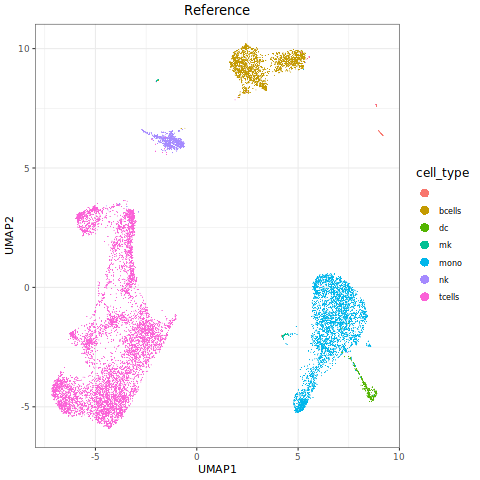

In [15]:
%%R

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

In [16]:
%%R
saveRDS(reference, './testing_reference1.rds')

In [17]:
# %%R
# # Read in Symphony reference to map to
# reference = readRDS('./testing_reference1.rds')

In [18]:
%%R
# Map query
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

R[write to console]: Scaling and synchronizing query gene expression

R[write to console]: Found 3451 out of 3451 reference variable genes in query dataset

R[write to console]: Project query cells using reference gene loadings

R[write to console]: Clustering query cells to reference centroids

R[write to console]: Correcting query batch effects

R[write to console]: UMAP

R[write to console]: All done!



In [19]:
%%R
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

### Visualization of mapping

In [20]:
%%R
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell_type_pred_knn_prob = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

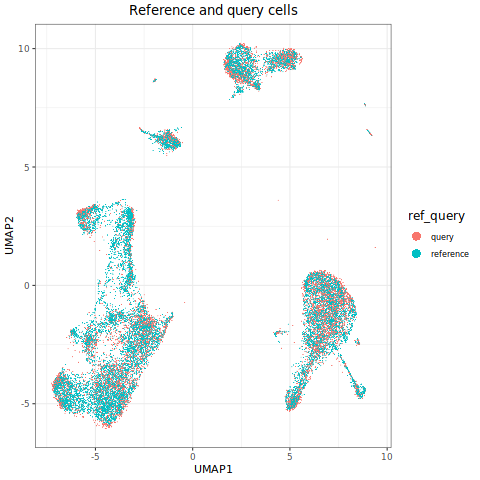

In [21]:
%%R
# Plot UMAP visualization of all cells
fig.size(3, 5)
plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

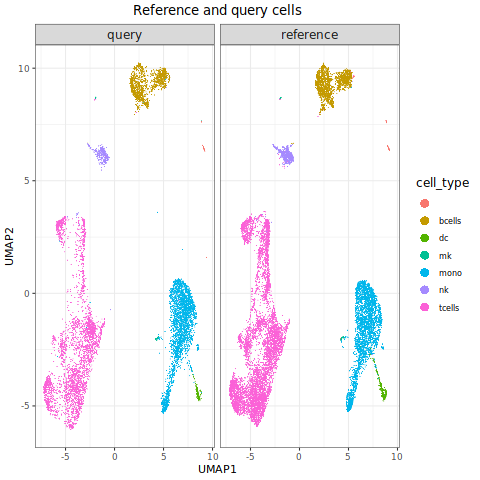

In [22]:
%%R
fig.size(3, 5)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query')

# symphonypy

In [ ]:
%%R -i RDS_fp,metadata_fp -o exprs_norm_for_py,metadata_for_py
exprs_norm_for_py = readRDS(RDS_fp)
metadata_for_py = read.csv(metadata_fp, row.names = 1)

In [ ]:
%%R
rm(exprs_norm_for_py)
rm(metadata_for_py)
gc()

In [ ]:
adata = ad.AnnData(exprs_norm_for_py.T)

In [ ]:
adata.obs = metadata_for_py
adata

In [ ]:
adata.obs.donor.value_counts()

In [23]:
# adata.write(os.path.join(JUPYTER_DIR, "data", "exprs_norm_all.h5ad"))

In [16]:
# adata = sc.read(os.path.join(JUPYTER_DIR, "data", "exprs_norm_all.h5ad"))

In [17]:
adata_query = adata[adata.obs.donor == "5'"].copy()
adata_query.obs["ref_query"] = "query"

adata_ref = adata[~(adata.obs.donor == "5'")].copy()
adata_ref.obs["ref_query"] = "ref"

In [18]:
n_comps = 20
batch_keys = [
    "donor",
]
harmony_kwargs = {"sigma": 0.1}
lamb = 1

In [19]:
preprocess_ref_PCA(adata_ref, n_comps=n_comps, batch_keys=batch_keys, raw_counts=False, n_top_genes=2000)
preprocess_query_PCA(adata_ref, adata_query, raw_counts=False)

# hard-coded for a while
query_basis = "X_pca_ref"
adjusted_basis = "X_pca_adjusted"

# TODO: add an ability to save object to disk
so = Symphony(adata_ref, batch_keys=batch_keys, harmony_kwargs=harmony_kwargs)

so.fit()
so.transform(
    adata_query,
    basis=query_basis,
    adjusted_basis=adjusted_basis,
    batch_keys=batch_keys,
    lamb=lamb,
)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
2022-12-26 03:16:10,884 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2022-12-26 03:16:12,908 - harmonypy - INFO - sklearn.KMeans initialization complete.
2022-12-26 03:16:13,145 - harmonypy - INFO - Iteration 1 of 10
2022-12-26 03:16:19,882 - harmonypy - INFO - Iteration 2 of 10
2022-12-26 03:16:26,717 - harmonypy - INFO - Iteration 3 of 10
2022-12-26 03:16:33,068 - harmon

In [20]:
k_neighbours = 10
labels = ['cell_type', 'cell_subtype']

In [21]:
adata_query_ct = adata_query.obs[labels].copy()
adata_query.obs[labels] = None

In [22]:
so.transfer_labels(adata_query, adjusted_basis, adjusted_basis, labels, k_neighbours)

In [23]:
(adata_query.obs[labels] == adata_query_ct).sum(axis=0)

cell_type       7612
cell_subtype    6591
dtype: int64

In [24]:
adata_query.shape

(7697, 33692)

In [27]:
adata_joined = adata_ref.concatenate(adata_query)
adata_joined

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 20886 × 33692
    obs: 'cell_id', 'donor', 'nUMI', 'nGene', 'percent_mito', 'cell_type', 'res_0.80', 'cell_subtype', 'ref_query', 'batch_symphonypy', 'batch'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'mean-0', 'std-0'
    obsm: 'X_pca_adjusted'

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


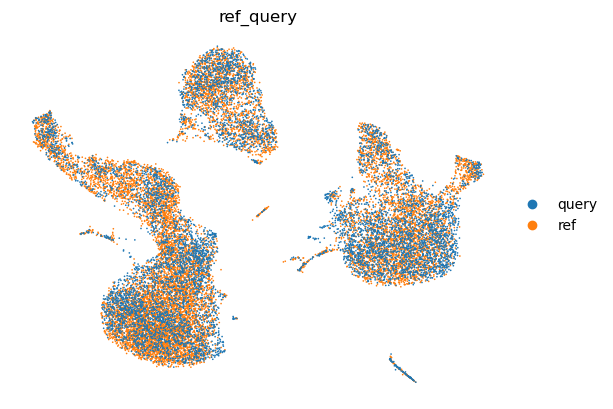

In [28]:
sc.pp.neighbors(
    adata_joined,
    n_pcs=n_comps,
    n_neighbors=20,
    knn=True,
    use_rep=adjusted_basis
)
sc.tl.umap(adata_joined)
sc.pl.umap(adata_joined, color=['ref_query'], frameon=False)